In [1]:
import os
from matplotlib.image import imread
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

In [2]:
train_folder = 'train_rotated_clustered_edges'
test_folder = 'test_rotated_clustered_edges'

### data analysis

In [3]:
print('number of files in train categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{train_folder}/{class_name}'))))

number of files in train categories:
paper: 612
rock: 626
scissors: 650


In [4]:
print('number of files in test categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{test_folder}/{class_name}'))))

number of files in test categories:
paper: 100
rock: 100
scissors: 100


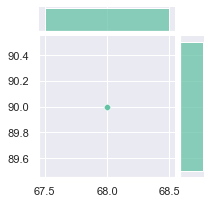

In [5]:
dim1 = []
dim2 = []
for dir1 in [train_folder,test_folder]:
    for dir2 in os.listdir(dir1):
        for img_name in os.listdir(dir1 + '\\' + dir2): 
            img = imread(dir1 + '\\' + dir2 + '\\' + img_name)
            d1,d2 = img.shape
            dim1.append(d1)
            dim2.append(d2)
sns.jointplot(x=dim1,y=dim2,height=3)

### image generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module tensorflow.python.keras.preprocessing.image:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Arguments:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 0.
 |      featurewise_std_normalization: Boolean.
 |          Divide inputs by std of the dataset, feature-wise.
 |      samplewise_std_normalization: Boolean. Divide each input by its std.
 |      zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
 |      zca_whitening: Boolean. Apply ZCA whitening.
 |      rotation_range: Int. Degree range for random rotations.
 |      width_shift_range: Float, 1-D array-like or int
 |          - float: fraction of total width, if < 1, or pixels if >= 1.
 |     

In [8]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=False,
                               fill_mode='nearest'
                              )

In [9]:
rock_img = imread(f'{train_folder}\\rock\\' + os.listdir(f'{train_folder}\\rock')[0])

(-0.5, 89.5, 67.5, -0.5)

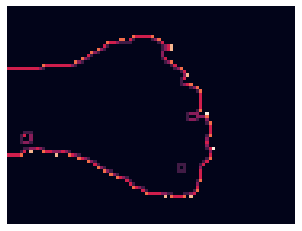

In [10]:
plt.imshow(rock_img)
plt.axis('off')

In [11]:
rock_img = rock_img.reshape(68,90,1)

(-0.5, 89.5, 67.5, -0.5)

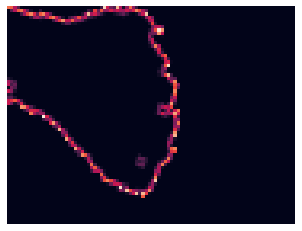

In [12]:
plt.imshow(image_gen.random_transform(rock_img))
plt.axis('off')

In [13]:
image_gen.flow_from_directory(train_folder)

Found 1888 images belonging to 3 classes.


In [14]:
image_gen.flow_from_directory(test_folder)

Found 300 images belonging to 3 classes.


### cnn model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [16]:
rock_img.shape

(68, 90, 1)

In [17]:
image_shape = (rock_img.shape[0], rock_img.shape[1], 1)

In [18]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 88, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 44, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 42, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 7, 32)          1

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

### training the model

In [21]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras_preprocessing.image.image_data_generator:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest') method of tensorflow.python.keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    # Arguments
        directory: string, path to the target directory.
            It should contain one subdirectory per class.
            Any PNG, JPG, BMP, PPM or TIF images
            inside each of the subdirectories directory tree
            will be included in the generator.
            See [this script](
            https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
            for more details.
        target_size: Tuple of integers `(height, width

In [22]:
batch_size = 16

In [23]:
train_image_gen = image_gen.flow_from_directory(train_folder,
                                                target_size=image_shape[:2],
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1888 images belonging to 3 classes.


In [24]:
test_image_gen = image_gen.flow_from_directory(test_folder,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 300 images belonging to 3 classes.

(-0.5, 89.5, 67.5, -0.5)

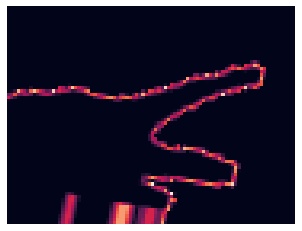

In [25]:
plt.imshow(train_image_gen.next()[0][0])
plt.axis('off')

(-0.5, 89.5, 67.5, -0.5)

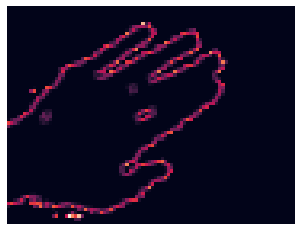

In [26]:
plt.imshow(test_image_gen.next()[0][0])
plt.axis('off')

In [27]:
train_image_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [28]:
start = time.time()

results = model.fit(train_image_gen,
                    epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

stop = time.time()
print('\n',(stop-start)//60,'min.')

Train for 118 steps, validate for 19 steps
Epoch 1/20
118/118 [==============================] - 12s 103ms/step - loss: 0.7258 - accuracy: 0.6716 - val_loss: 0.3766 - val_accuracy: 0.8433
Epoch 2/20
118/118 [==============================] - 12s 98ms/step - loss: 0.3964 - accuracy: 0.8506 - val_loss: 0.2538 - val_accuracy: 0.9067
Epoch 3/20
118/118 [==============================] - 11s 94ms/step - loss: 0.2699 - accuracy: 0.9057 - val_loss: 0.1882 - val_accuracy: 0.9433
Epoch 4/20
118/118 [==============================] - 11s 94ms/step - loss: 0.2254 - accuracy: 0.9200 - val_loss: 0.2610 - val_accuracy: 0.9067
Epoch 5/20
118/118 [==============================] - 11s 94ms/step - loss: 0.2435 - accuracy: 0.9131 - val_loss: 0.1932 - val_accuracy: 0.9333

 0.0 min.


In [29]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")
model.save('models_rotated_clustered_edges\\' + timestamp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models_rotated_clustered_edges\2024-04-06--16-46\assets


### model evaluation

In [30]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

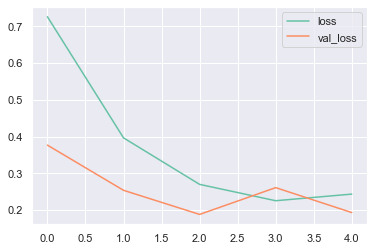

In [31]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

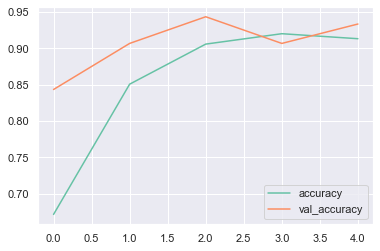

In [32]:
losses[['accuracy','val_accuracy']].plot()

In [33]:
model.metrics_names

['loss', 'accuracy']

In [34]:
model.evaluate(test_image_gen)

19/19 [==============================] - 1s 31ms/step - loss: 0.1909 - accuracy: 0.9300


[0.19086577561929038, 0.93]

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [36]:
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

In [37]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90       100
           1       0.93      1.00      0.96       100
           2       0.92      0.98      0.95       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



In [38]:
cm = confusion_matrix(test_image_gen.classes,predictions)
cm

array([[ 84,   8,   8],
       [  0, 100,   0],
       [  2,   0,  98]], dtype=int64)

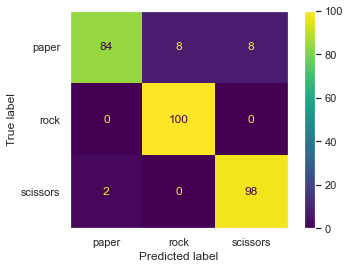

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_image_gen.class_indices)
disp.plot()
plt.grid(False)
plt.show()